In [1]:
!pip install pmdarima

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from math import floor,ceil,sqrt
import sys
import warnings
import datetime as dt

if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00


In [2]:
data = pd.read_csv('/kaggle/input/uniqlo-fastretailing-stock-price-prediction/Uniqlo(FastRetailing) 2012-2016 Training - stocks2012-2016.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Stock Trading
0,2016-12-30,42120,42330,41700,41830,610000,25628028000
1,2016-12-29,43000,43220,42540,42660,448400,19188227000
2,2016-12-28,43940,43970,43270,43270,339900,14780670000
3,2016-12-27,43140,43700,43140,43620,400100,17427993000
4,2016-12-26,43310,43660,43090,43340,358200,15547803000


In [3]:
data.isna().any()

Date             False
Open             False
High             False
Low              False
Close            False
Volume           False
Stock Trading    False
dtype: bool

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           1226 non-null   object
 1   Open           1226 non-null   int64 
 2   High           1226 non-null   int64 
 3   Low            1226 non-null   int64 
 4   Close          1226 non-null   int64 
 5   Volume         1226 non-null   int64 
 6   Stock Trading  1226 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 67.2+ KB


Text(0.5, 1.0, 'Stock Price of UNIQLO over the Years')

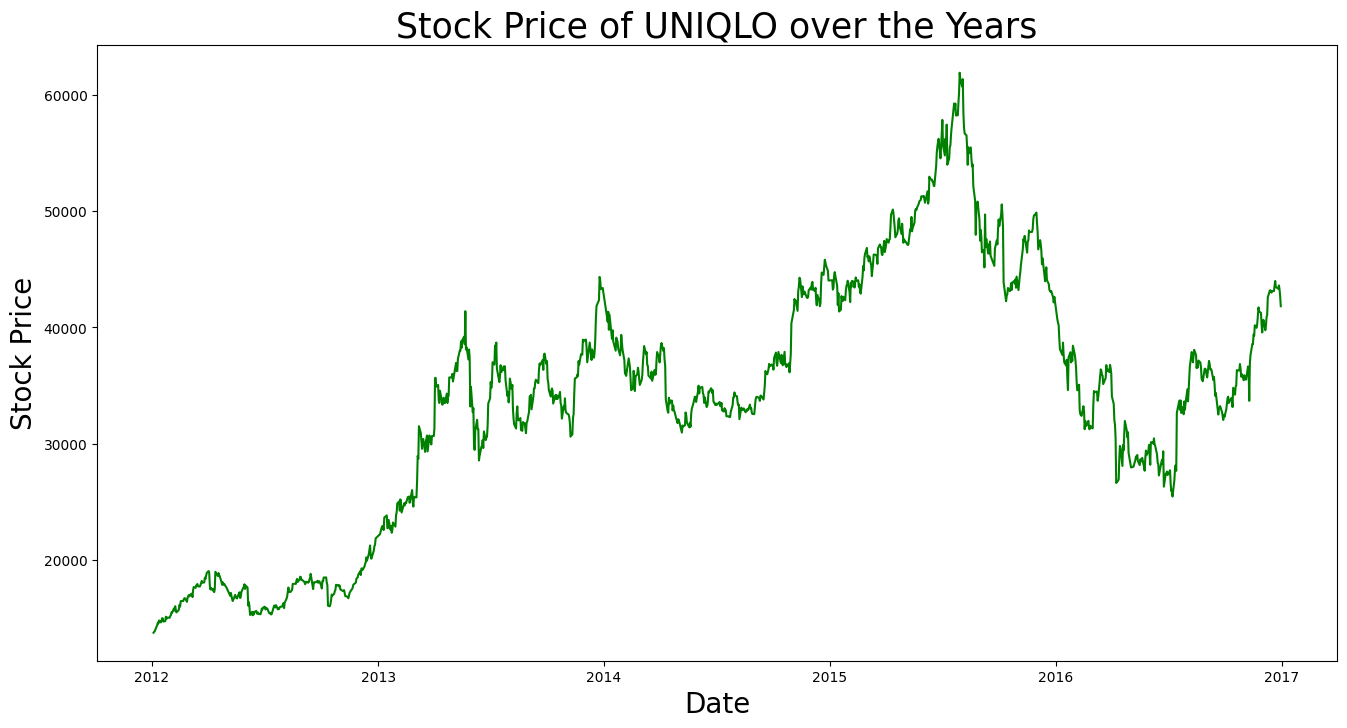

In [5]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Date'] = data['Date'].dt.strftime('%d-%m-%Y') 
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.index = data['Date']
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of UNIQLO over the Years',size=25)

In [6]:
#stop

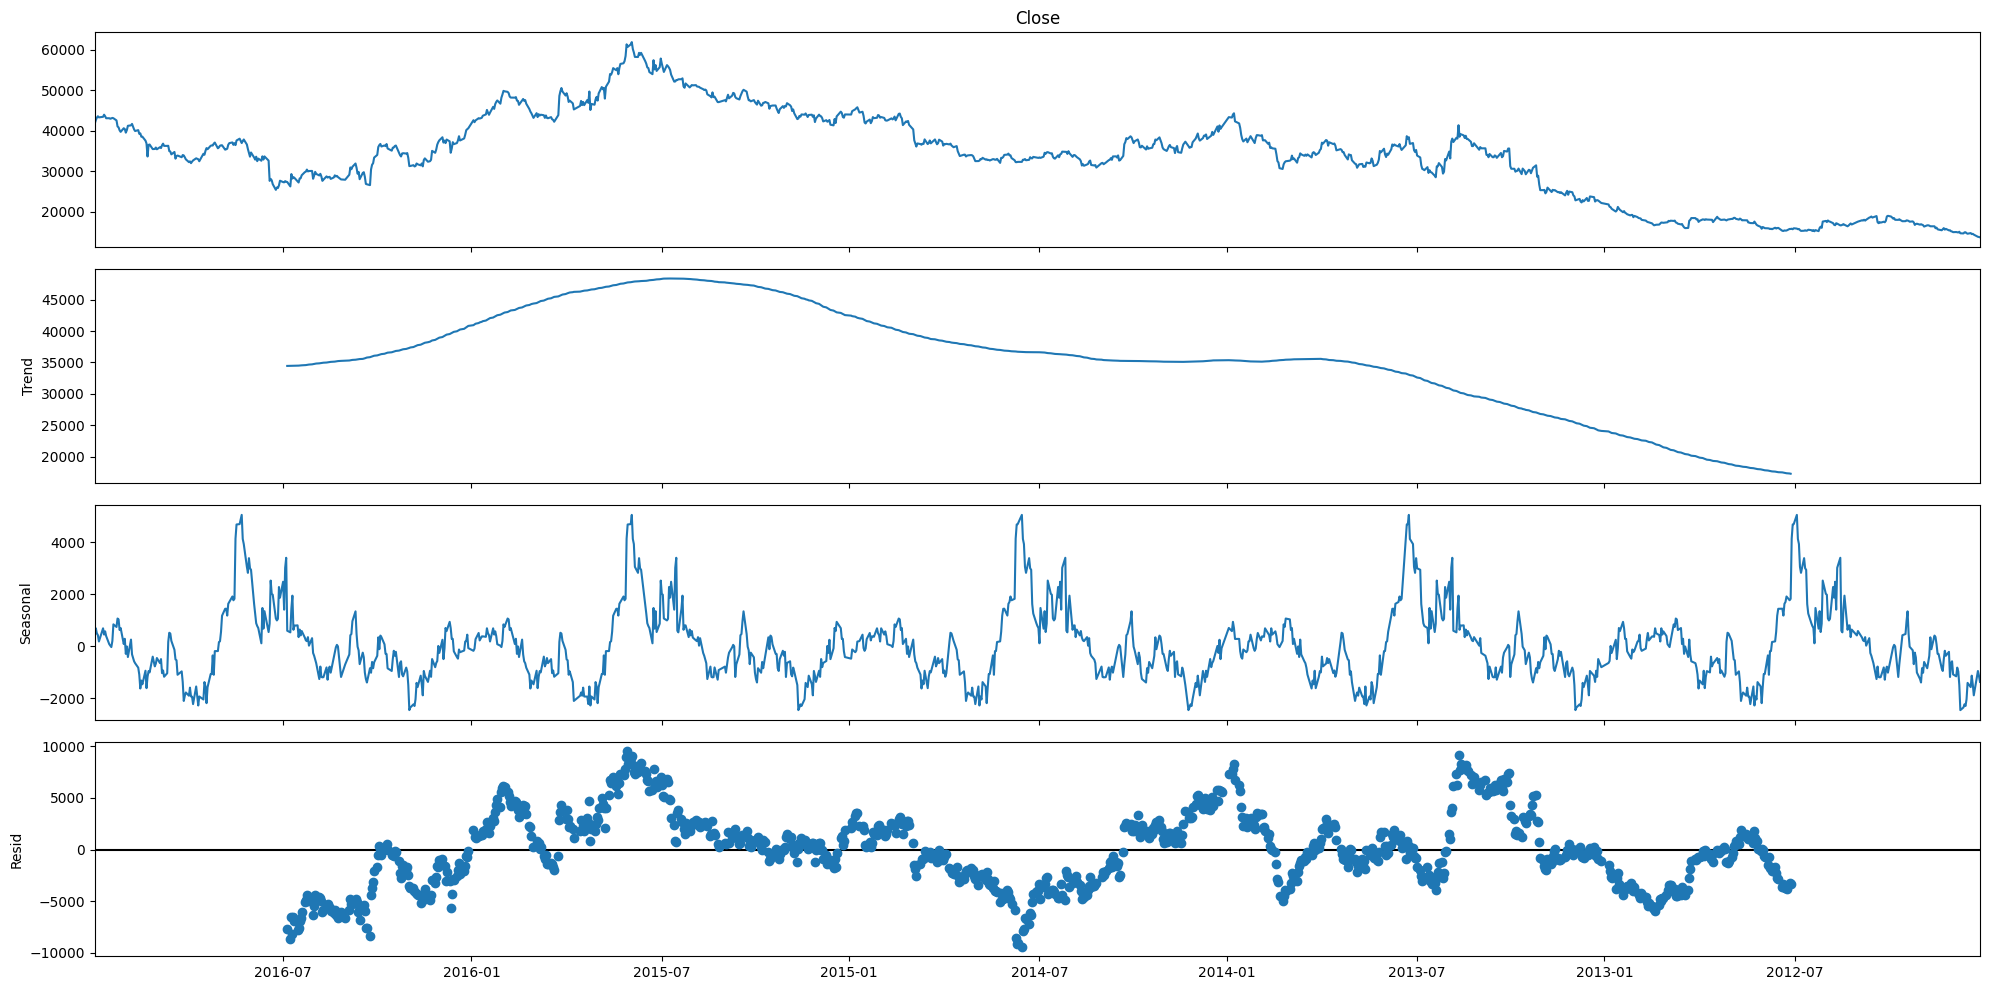

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive', period=252)  # Assuming ~252 trading days per year
result.plot()
plt.show()

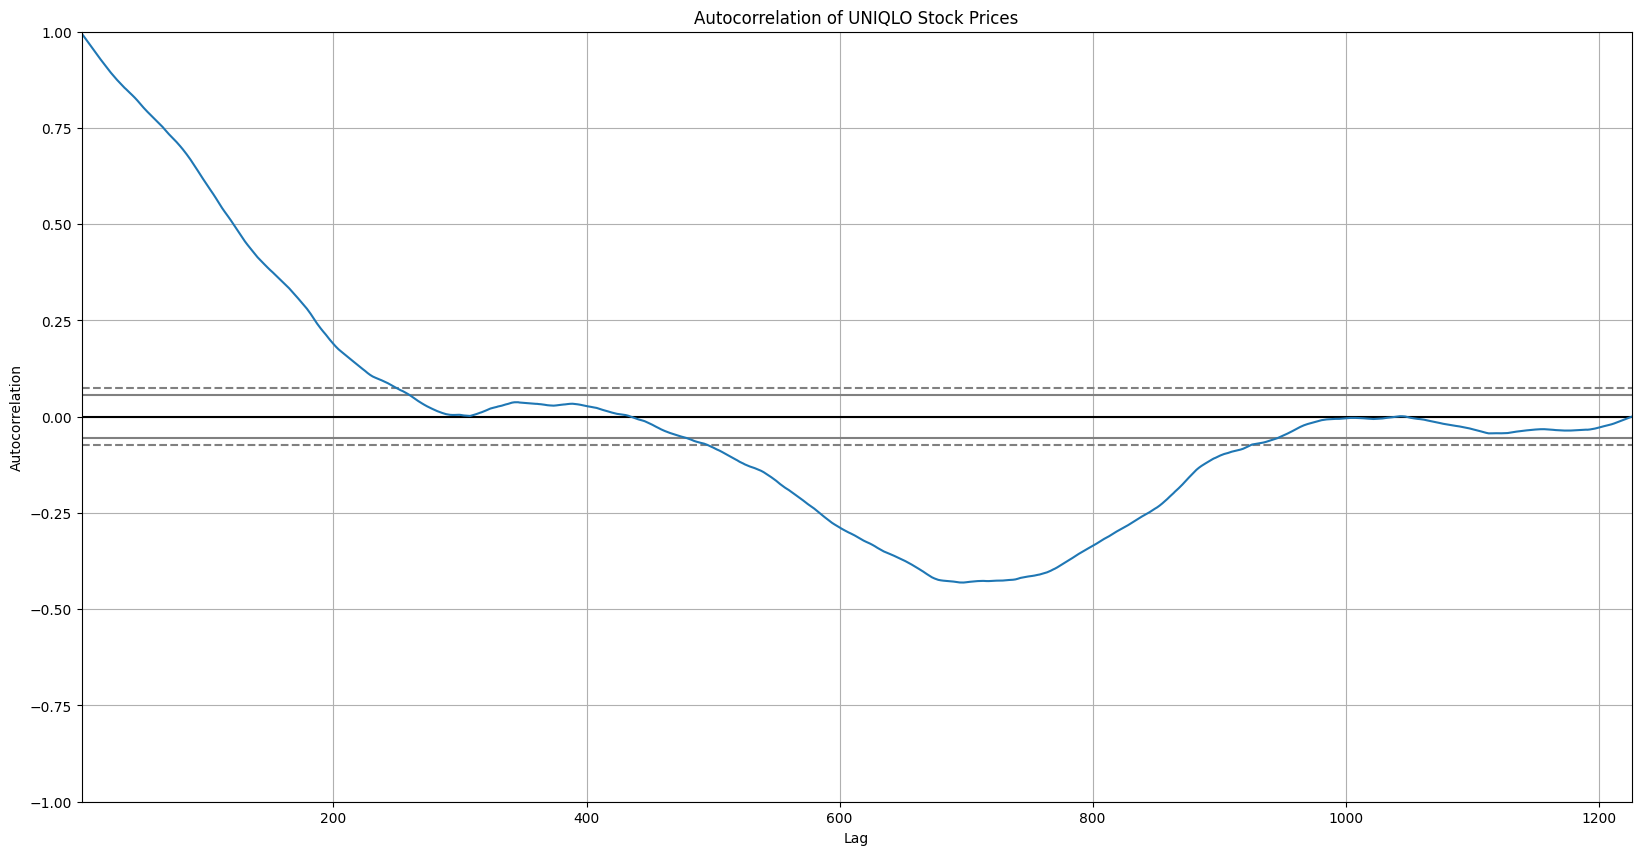

In [8]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data['Close'])
plt.title('Autocorrelation of UNIQLO Stock Prices')
plt.show()

In [9]:
def lstm_prediction(data):
    shape=data.shape[0]
    data_new=data[['Close']]
    data_new.head()
    dataset = data_new.values
    train=data_new[:ceil(shape*0.75)]
    valid=data_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = data_new[len(data_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (920, 1)
Shape of Validation Set (306, 1)
880/880 - 16s - 18ms/step - loss: 0.0031
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
RMSE value on validation set: 2764.756677532066
-----------------------------------------------------------
-----------------------------------------------------------


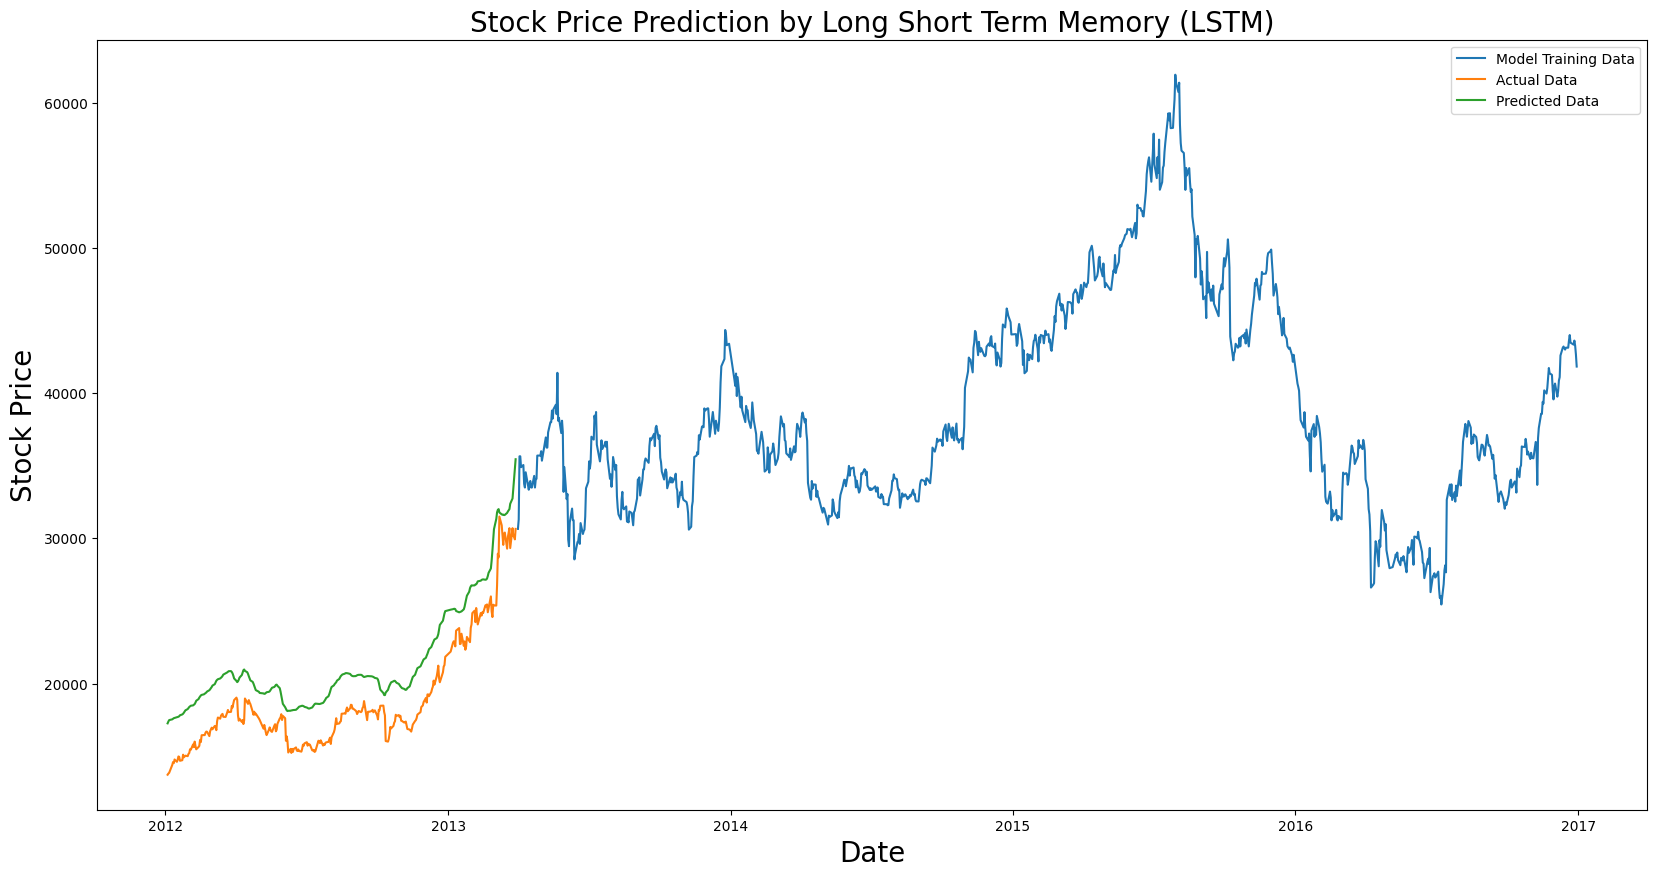

In [10]:
lstm_prediction(data)

In [11]:
!pip install prophet

In [12]:
from prophet import Prophet
def fb_prophet_prediction(data):
    shape = data.shape[0]
    data_new = data[['Close']]
    data_new.reset_index(inplace=True)
    
    # Ensure that the Date column is converted to datetime correctly
    data_new['Date'] = pd.to_datetime(data_new['Date'], format='%d-%m-%Y')  # Correct format
    data_new.index = data_new['Date']
    
    # Rename columns for Prophet
    data_new.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
    
    # Split into training and validation sets
    train_set = data_new.iloc[:ceil(shape * 0.75)]
    valid_set = data_new.iloc[ceil(shape * 0.75):]
    
    print('-------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY FB PROPHET-----------')
    print('-------------------------------------------------------')
    print('Shape of Training Set', train_set.shape)
    print('Shape of Validation Set', valid_set.shape)
    
    # Initialize Prophet model
    model = Prophet()
    model.fit(train_set)
    
    # Make future dataframe for predictions
    close_prices = model.make_future_dataframe(periods=len(valid_set))
    
    # Predict future values
    forecast = model.predict(close_prices)
    forecast_valid = forecast['yhat'][ceil(shape * 0.75):]
    
    # Calculate RMSE
    rms = np.sqrt(np.mean(np.power((np.array(valid_set['y']) - np.array(forecast_valid)), 2)))
    print('RMSE value on validation set:', rms)
    
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    # Add predictions to validation set
    valid_set['Predictions'] = forecast_valid.values
    
    # Plot the results
    plt.figure(figsize=(16, 8))
    plt.plot(train_set['y'], label='Model Training Data')
    plt.plot(valid_set['y'], label='Actual Data')
    plt.plot(valid_set['Predictions'], label='Predicted Data')
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by FB Prophet', size=20)
    plt.legend()

-------------------------------------------------------
-----------STOCK PRICE PREDICTION BY FB PROPHET-----------
-------------------------------------------------------
Shape of Training Set (920, 2)
Shape of Validation Set (306, 2)


05:11:24 - cmdstanpy - INFO - Chain [1] start processing
05:11:24 - cmdstanpy - INFO - Chain [1] done processing


RMSE value on validation set: 22057.489735763687
-----------------------------------------------------------
-----------------------------------------------------------


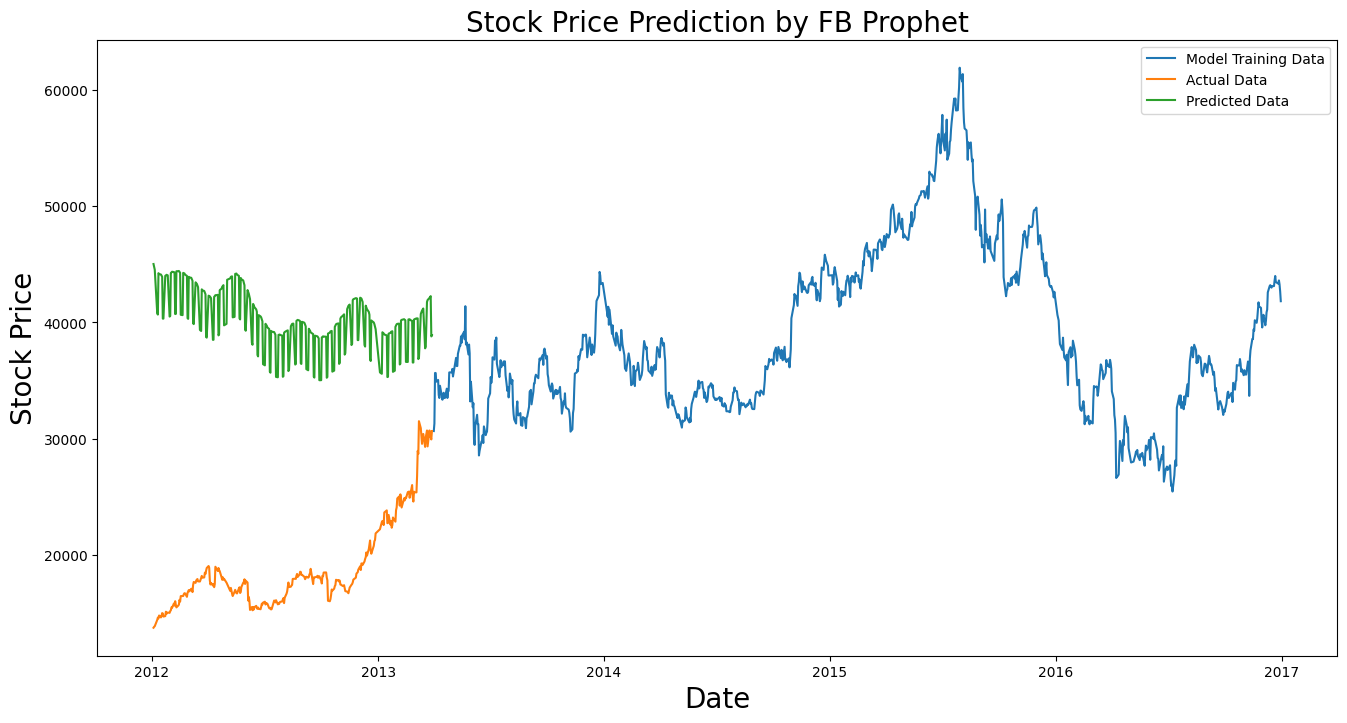

In [13]:
fb_prophet_prediction(data)